Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'C': 1, 'max_iter': 1000, 'tol': 0.001}
SVM score after tuning:  0.9820627802690582
SVM confusion matrix after tuning: 
 [[767   3]
 [ 13 109]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       770
        spam       0.97      0.89      0.93       122

    accuracy                           0.98       892
   macro avg       0.98      0.94      0.96       892
weighted avg       0.98      0.98      0.98       892



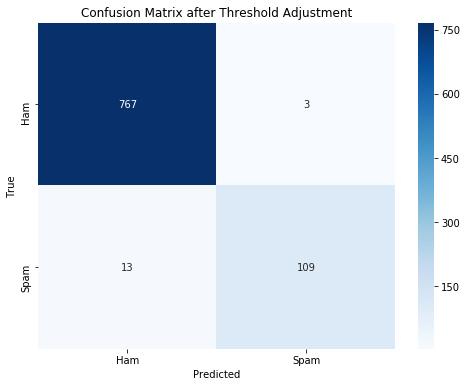

Cross-validation scores: [0.97619048 0.97755961 0.97475456 0.98176718 0.98737728]
Mean cross-validation accuracy: 0.9795


In [2]:
# 最终代码
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 读邮件数据CSV
train_email = pd.read_csv("C:/Users/Administrator/Desktop/work1/data/train.csv", usecols=[2], encoding='Windows-1252')
train_label = pd.read_csv("C:/Users/Administrator/Desktop/work1/data/train.csv", usecols=[1], encoding='Windows-1252')

# 数据预处理
def text_processing(text):
    text = text.lower()
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join([word for word in str(text).split() if word not in stopwords.words('english')])
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = " ".join([PorterStemmer().stem(word) for word in text.split()])
    return text

train_email['Email'] = train_email['Email'].apply(text_processing)

# 将内容转为list类型
train_email = np.array(train_email['Email']).reshape((1, len(train_email)))[0].tolist()
train_label = np.array(train_label).reshape((1, len(train_email)))[0].tolist()

# 构造训练集和验证集
train_num = int(len(train_email)*0.8)
data_train = train_email[:train_num]
data_dev = train_email[train_num:]
label_train = train_label[:train_num]
label_dev = train_label[train_num:]

# 使用词袋模型并调参
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)
data_train_cnt = vectorizer.fit_transform(data_train)
data_test_cnt = vectorizer.transform(data_dev)

# 变成TF-IDF矩阵并调参
transformer = TfidfTransformer(sublinear_tf=True, use_idf=True)
data_train_tfidf = transformer.fit_transform(data_train_cnt)
data_test_tfidf = transformer.transform(data_test_cnt)

# SVM模型超参数调优
svm = LinearSVC(random_state=42)
param_grid = {
    'C': [0.1, 1, 10, 100],  # C值的选择
    'max_iter': [1000, 2000],  # 最大迭代次数
    'tol': [1e-3, 1e-4]  # 收敛容忍度
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(data_train_tfidf, label_train)

# 输出最佳参数
print("Best parameters found: ", grid_search.best_params_)

# 使用最优参数训练SVM模型
best_svm = grid_search.best_estimator_
best_svm.fit(data_train_tfidf, label_train)

# 测试集评分
score = best_svm.score(data_test_tfidf, label_dev)
print("SVM score after tuning: ", score)

# 预测结果
result_svm = best_svm.predict(data_test_tfidf)
print("SVM confusion matrix after tuning: \n", confusion_matrix(label_dev, result_svm))

# 输出更详细的分类报告
print("Classification Report:\n", classification_report(label_dev, result_svm))

# 可视化混淆矩阵
conf_matrix = confusion_matrix(label_dev, result_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix after Threshold Adjustment')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('最终结果.png', dpi=600)
plt.show()

# 交叉验证：使用5折交叉验证来评估模型性能
cross_val_scores = cross_val_score(best_svm, data_train_tfidf, label_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation accuracy: {cross_val_scores.mean():.4f}")
